The following code is organized in different functions.

**ATTENTION**: at the beginning of the challenge we hold out the validation set and then we zipped the dataset, to use the same dataset split throughout the challenge. The code expects the zip of the dataset ('new_Dataset_15.zip') inside a folder called 'Challenge_1' in your google drive. Every file is saved inside 'Challenge_1' folder. 
Here the link to download the dataset splitted in training and validation: https://drive.google.com/file/d/1GS7NrVsTABV46iuJAOgh0TYGJD-aRErR/view?usp=sharing




# Initial Setup



In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

# Set the seed for random operations. 
# Letting experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
drive  sample_data


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# Dataset retrivial

In this section there is the code used at the beginning of the challenge used to implement the hold out of the validation set. It was executed once, then we zipped the dataset to use the same dataset split throughout the challenge. The link to download the dataset is the following https://drive.google.com/file/d/1GS7NrVsTABV46iuJAOgh0TYGJD-aRErR/view?usp=sharing

In [ ]:
#! unzip '/content/drive/My Drive/Challenge_1/artificial-neural-networks-and-deep-learning-2020.zip'

In [ ]:
#import json
#ground_truth = json.load(open('/content/MaskDataset/train_gt.json'))

#! mkdir '/content/MaskDataset/training/NO PERSON'
#! mkdir '/content/MaskDataset/training/ALL THE PEOPLE'
#! mkdir '/content/MaskDataset/training/SOMEONE'

#! mkdir '/content/MaskDataset/validation'
#! mkdir '/content/MaskDataset/validation/NO PERSON'
#! mkdir '/content/MaskDataset/validation/ALL THE PEOPLE'
#! mkdir '/content/MaskDataset/validation/SOMEONE'

In [ ]:
# -------------------------------------------------------------------------------
# Random validation split of the training dataset. Runned once and then we zipped
# the dataset to use the same dataset split throughout the challenge.
# -------------------------------------------------------------------------------
'''
import shutil

validation_split = 0.15

for i in ground_truth:
  tmp_path = os.path.join(cwd, 'MaskDataset/training', i)
  rnd = tf.random.uniform(shape=[], maxval=1, dtype=tf.float32)
  if ground_truth[i] == 0:
    if rnd.numpy() > validation_split:
      shutil.move(tmp_path, "/content/MaskDataset/training/NO PERSON")
    else:
      shutil.move(tmp_path, "/content/MaskDataset/validation/NO PERSON")
  elif ground_truth[i] == 1:
    if rnd.numpy() > validation_split:
      shutil.move(tmp_path, "/content/MaskDataset/training/ALL THE PEOPLE")
    else:
      shutil.move(tmp_path, "/content/MaskDataset/validation/ALL THE PEOPLE")
  else:
    if rnd.numpy() > validation_split:
      shutil.move(tmp_path, "/content/MaskDataset/training/SOMEONE")
    else:
      shutil.move(tmp_path, "/content/MaskDataset/validation/SOMEONE")
'''

In [ ]:
# ------------------------------------------------------------------------------------------
# Zip the splitted dataset for the next executions, to avoid the splitting process each time
# ------------------------------------------------------------------------------------------
#! zip -r '/content/drive/My Drive/Challenge_1/new_MaskDataset_15.zip' 'MaskDataset'

Here the code to unzip 'new_Dataset_15.zip' expected in the 'Challenge_1' folder inside google drive.

In [ ]:
! unzip '/content/drive/My Drive/Challenge_1/new_MaskDataset_15.zip'

# Dataset setup

In [ ]:
# --------------------------------------------------------------------------------------
# Create the training and validation ImageDataGenerator objects for from scratch network
# --------------------------------------------------------------------------------------
def data_generator(apply_data_augmentation):
  
  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  # Create the train ImageDataGenerator object with or without data augmentation
  if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range = 30,
                                        width_shift_range = 10,
                                        height_shift_range = 10,
                                        zoom_range = 0.3,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        fill_mode = 'constant',
                                        cval = 0,
                                        rescale = 1./255)
  else:
    train_data_gen = ImageDataGenerator(rescale = 1./255)

  # Create the validation ImageDataGenerator object
  val_data_gen = ImageDataGenerator(rescale = 1./255)

  return train_data_gen, val_data_gen

In [ ]:
# -----------------------------------------------------------------------------------
# Create the training and validation ImageDataGenerator objects for transfer learning 
# -----------------------------------------------------------------------------------
def data_generator_tl(apply_data_augmentation):

  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  
  # Import the input preprocessing function used by the pre-trained network used in transfer learning
  from tensorflow.keras.applications.efficientnet import preprocess_input

  # Create the train ImageDataGenerator object with or without data augmentation
  if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range = 30,
                                        width_shift_range = 10,
                                        height_shift_range = 10,
                                        zoom_range = 0.3,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        fill_mode = 'constant',
                                        cval = 0,
                                        #shear_range=28,
                                        preprocessing_function=preprocess_input)
  else:
    train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

  # Create the validation ImageDataGenerator objects
  val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

  return train_data_gen, val_data_gen

In [ ]:
# -------------------------------------------------------
# Create generators to read images from dataset directory
# -------------------------------------------------------
def flow_from_data_gen(train_data_gen, val_data_gen, bs = 64, img_h = 256, img_w = 256, num_classes = 3):
  
  dataset_dir = os.path.join(cwd, 'MaskDataset')

  # Classes label to index mapping 
  classes = ['NO PERSON',       # 0
             'ALL THE PEOPLE',  # 1
             'SOMEONE']         # 2

  # Training
  # --------
  training_dir = os.path.join(dataset_dir, 'training')
  train_gen = train_data_gen.flow_from_directory(training_dir,
                                                 batch_size=bs,
                                                 classes=classes,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 target_size=(img_h, img_w),
                                                 seed=SEED)  # targets are directly converted into one-hot vectors
  # --------

  # Validation
  # ----------
  validation_dir = os.path.join(dataset_dir, 'validation')
  valid_gen = val_data_gen.flow_from_directory(validation_dir,
                                               batch_size=bs, 
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               target_size=(img_h, img_w),
                                               seed=SEED)
  # ----------

  # Check if the labels are assigned correctly
  train_gen.class_indices

  return train_gen, valid_gen

In [ ]:
# -----------------------------------------------
# Create the train and validation dataset objects
# -----------------------------------------------
def create_dataset(train_gen, valid_gen, img_h = 256, img_w = 256, num_classes = 3):
  
  # Training
  # --------
  train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
  train_dataset = train_dataset.repeat()
  # ----------

  # Validation
  # ----------
  valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
  valid_dataset = valid_dataset.repeat()
  # ----------

  return train_dataset, valid_dataset

In [ ]:
# --------------------------------------------------------------
# Visualize the first validation image in the validation dataset
# --------------------------------------------------------------
def visualize_validation_image(valid_dataset):
  from PIL import Image
  from matplotlib.pyplot import imshow
  
  test_iter = iter(valid_dataset)

  # Get a test image
  test_img = next(test_iter)[0]
  test_img = test_img[0]

  # Visualize the image
  imshow(Image.fromarray(np.uint8(np.array(test_img))))

# Model setup

In [ ]:
# -----------------------------------------------------------------
# Define the model created from scratch (without transfer learning)
# -----------------------------------------------------------------
def define_model(kernel_depth = 32, depth = 5, img_h = 256, img_w = 256, double_conv = True, vgg_like = False, increase_kernel_depth = True, num_dense = 2, neurons_1 = 256, neurons_2 = 64, neurons_3 = 32, num_classes = 3):
  
  model = tf.keras.Sequential()

  # Features extraction network
  # ---------------------------
  for i in range(depth):

    # Set the input shape
    if i == 0:
        input_shape = [img_h, img_w, 3]
    else:
        input_shape=[None]

    # Conv block: Conv2D -> [Conv2D -> [Conv2D ->]] Activation -> Pooling
    model.add(tf.keras.layers.Conv2D(filters=kernel_depth, 
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same',
                                     input_shape=input_shape,
                                     activation='relu', 
                                     kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))

    # Add a second convolution in each the convolution block (optional)
    if double_conv:
      model.add(tf.keras.layers.Conv2D(filters=kernel_depth, 
                                       kernel_size=(3, 3),
                                       strides=(1, 1),
                                       padding='same',
                                       input_shape=input_shape,
                                       activation='relu', 
                                       kernel_initializer='he_uniform'))
      model.add(tf.keras.layers.BatchNormalization(momentum=0.9))

      # Add a third convolution for the convolution blocks near to the output as done in VGG networks (optional)
      if vgg_like:

        if i > 4:
          model.add(tf.keras.layers.Conv2D(filters=kernel_depth, 
                                           kernel_size=(3, 3),
                                           strides=(1, 1),
                                           padding='same',
                                           input_shape=input_shape,
                                           activation='relu', 
                                           kernel_initializer='he_uniform'))
          model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    # Incremental dropout layer (higher closer to the output)
    model.add(tf.keras.layers.Dropout(0.2 + (i/10)))
    
    if increase_kernel_depth:
      kernel_depth *= 2 
      # We increase the number of features as we go deeper into the network:
      # low level features  are colors or edges so the number of useful feature
      # at this level is low instead high level features are very useful
      # for classification.
  # ---------------------------
  
  # Fully Connected neural network (i.e. classifier)
  # ------------------------------------------------
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=neurons_1, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  model.add(tf.keras.layers.Dropout(0.5))

  if num_dense >= 2:
    model.add(tf.keras.layers.Dense(units=neurons_2, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(0.5))
  if num_dense >= 3:
    model.add(tf.keras.layers.Dense(units=neurons_3, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(0.5))
  
  model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
  # ------------------------------------------------

  # Visualize created model as a table
  model.summary()

  return model

In [ ]:
# --------------------------------------
# Define the model for transfer learning
# --------------------------------------
def define_transfer_learning_model(img_h = 600, img_w = 600, num_dense = 1, neurons_1 = 16, neurons_2 = 8, neurons_3 = 4, num_classes = 3):

  # Import the EfficientNet-B7 used in transfer learning
  from tensorflow.keras.applications import EfficientNetB7

  # Retrieving the model without the classification network on the top
  base_model = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

  # Replace all Batch Normalization layers by Group Normalization layers for more stability with small barth sizes
  #for i, layer in enumerate(base_model.layers):
  #  if "_bn" in layer.name:
  #    base_model.layers[i] = tfa.layers.GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

  # Set the model to be not trainable
  base_model.trainable = False
  for layer in base_model.layers:
    layer.trainable = False
    # Print the layer of the EfficientNet-B7 and if they are set to trainable
    print(str(layer.name) + ' '*(35 - len(str(layer.name))) + '----> Trainable: ' + str(layer.trainable))

  model = tf.keras.Sequential()
  # Feature extraction network
  # --------------------------
  model.add(base_model)
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  #model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  model.add(tf.keras.layers.Dropout(0.5))
  # --------------------------

  # Classification network
  # ----------------------
  model.add(tf.keras.layers.Dense(units=neurons_1, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
  #model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  #model.add(tf.keras.layers.Dropout(0.2))
  # ----------------------

  if num_dense >= 2:
    model.add(tf.keras.layers.Dense(units=neurons_2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(0.3))
  if num_dense >= 3:
    model.add(tf.keras.layers.Dense(units=neurons_3, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Dropout(0.4))

  model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

  # Visualize created model as a table
  model.summary()

  return model

In [ ]:
# --------------------------------
# Define the model for fine tuning
# --------------------------------
def define_fine_tuning_model(img_h = 600, img_w = 600, num_dense = 1, neurons_1 = 16, neurons_2 = 8, neurons_3 = 4, num_classes = 3):

  # Import the EfficientNet-B7 used in transfer learning
  from tensorflow.keras.applications import EfficientNetB7

  # Retrieving the model without the classification network on the top
  base_model = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

  base_model.trainable = True
  for layer in base_model.layers:
    layer.trainable = False

    #if ("block4" in layer.name):
    #  layer.trainable = True
    if ("block5" in layer.name):
      layer.trainable = True
    if ("block6" in layer.name):
      layer.trainable = True
    if ("block7" in layer.name):
      layer.trainable = True
    if "_bn" in layer.name:
      layer.trainable = False
    if 'top_conv' == layer.name:
      layer.trainable = True
    if 'top_activation' == layer.name:
      layer.trainable = True

    # Print the layer of the EfficientNet-B7 and if they are set to trainable
    print(str(layer.name) + ' '*(35 - len(str(layer.name))) + '----> Trainable: ' + str(layer.trainable))

  model = tf.keras.Sequential()
  model.add(base_model)
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  #model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(units=neurons_1, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
  #model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  #model.add(tf.keras.layers.Dropout(0.2))

  #if num_dense >= 2:
  #  model.add(tf.keras.layers.Dense(units=neurons_2, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
  #  model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  #  model.add(tf.keras.layers.Dropout(0.3))
  #if num_dense >= 3:
  #  model.add(tf.keras.layers.Dense(units=neurons_3, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
  #  model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  #  model.add(tf.keras.layers.Dropout(0.4))

  model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

  # Visualize created model as a table
  model.summary()

  return model

In [ ]:
# -----------------
# Compile the model
# -----------------
def compile_model(model, lr = 1e-4):

  # Optimization parameters
  # -----------------------

  # Loss
  # ----
  loss = tf.keras.losses.CategoricalCrossentropy()
  # ----

  # Optimization function
  # ---------------------
  optimizer = tfa.optimizers.RectifiedAdam(learning_rate=lr)
  # ---------------------

  # Validation metrics
  # ------------------
  metrics = ['accuracy']
  # ------------------

  # -----------------------
  
  # Compile the model
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

In [ ]:
# -----------------
# Set the callbacks
# -----------------
def set_callbacks(type = 'transfer_learning', model_checkpoint = True, visualize_tensorboard = False, early_stop = True, reduce_lr_on_plateau = True):
  
  import os
  from datetime import datetime

  cwd = os.getcwd()

  exps_dir = os.path.join('/content/drive/My Drive/Challenge_1/', 'classification_experiments')
  if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

  model_name = type

  exp_dir = os.path.join(exps_dir, model_name)
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []

  # Model checkpoint
  # ----------------
  if model_checkpoint:
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                       save_weights_only=True,
                                                       save_best_only=True)  # False to save the model directly
    callbacks.append(ckpt_callback)
  # ----------------

  # Visualize Learning on Tensorboard
  # ---------------------------------
  if visualize_tensorboard:
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
    
    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)  # if 1 shows weights histograms
    callbacks.append(tb_callback)
  # ---------------------------------

  # Early Stopping
  # --------------
  if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience = 15,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)
  # --------------

  # Reduce Learning rate on plateau
  # -------------------------------
  if reduce_lr_on_plateau:
    rlr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.5, 
                                                        patience=4, 
                                                        verbose=1, 
                                                        mode='auto', 
                                                        min_delta=0.0001)
    callbacks.append(rlr_callback)
  # -------------------------------

  return callbacks

In [ ]:
# -----------
# Train model
# -----------
def train_model(model, train_dataset, train_gen, valid_dataset, valid_gen, callbacks, num_epochs = 100):
  
  history_model = model.fit(x = train_dataset,
                            epochs = num_epochs,
                            steps_per_epoch = len(train_gen),
                            validation_data = valid_dataset,
                            validation_steps = len(valid_gen), 
                            callbacks=callbacks)
  
  return history_model

# Training

In [ ]:
# ------------------------------------
# Train the model created from scratch
# ------------------------------------
def train_from_scratch_model():
  
  apply_data_augmentation = True

  [train_data_gen, val_data_gen] = data_generator(apply_data_augmentation)

  [train_gen, valid_gen] = flow_from_data_gen(train_data_gen, val_data_gen, bs = 32, img_h = 512, img_w = 512, num_classes = 3)

  [train_dataset, valid_dataset] = create_dataset(train_gen, valid_gen, img_h = 512, img_w = 512, num_classes = 3)

  model = define_model(kernel_depth = 32, depth = 4, img_h = 512, img_w = 512, double_conv = True, vgg_like = False, increase_kernel_depth = True, num_dense = 2, neurons_1 = 256, neurons_2 = 128, num_classes = 3)

  model = compile_model(model, lr = 1e-4)

  callbacks = set_callbacks('CNN_from_scratch', model_checkpoint = True, visualize_tensorboard = False, early_stop = True, reduce_lr_on_plateau = True)

  history = train_model(model, train_dataset, train_gen, valid_dataset, valid_gen, callbacks, num_epochs = 200)

  plot_history(history)

  return model

In [ ]:
# --------------------------------------
# Train the model with transfer learning
# --------------------------------------
def train_transfer_learning():
  
  apply_data_augmentation = True

  img_h = 600
  img_w = 600

  num_classes = 3

  bs = 16

  num_dense = 1
  neurons_1 = 16

  lr = 0.00005

  num_epochs = 70

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = False
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Dense layer number                ---> ' + str(num_dense))
  print('Neurons in 1st dense              ---> ' + str(neurons_1))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [train_data_gen, val_data_gen] = data_generator_tl(apply_data_augmentation)

  [train_gen, valid_gen] = flow_from_data_gen(train_data_gen, val_data_gen, bs = bs, img_h = img_h, img_w = img_w, num_classes = num_classes)

  [train_dataset, valid_dataset] = create_dataset(train_gen, valid_gen, img_h = img_h, img_w = img_w, num_classes = num_classes)

  model = define_transfer_learning_model(img_h = img_h, img_w = img_w, num_dense = num_dense, neurons_1 = neurons_1, num_classes = num_classes)

  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('transfer_learning', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, train_gen, valid_dataset, valid_gen, callbacks, num_epochs = num_epochs)

  plot_history(history)

  return model, history

In [ ]:
# -------------------------------------------------------------------------
# Train the model (already trained with transfer learning) with fine tuning
# -------------------------------------------------------------------------
def train_fine_tuning():
  
  apply_data_augmentation = True

  img_h = 600
  img_w = 600

  num_classes = 3

  bs = 12

  num_dense = 1
  neurons_1 = 16

  lr = 0.00005

  num_epochs = 50

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = True
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Dense layer number                ---> ' + str(num_dense))
  print('Neurons in 1st dense              ---> ' + str(neurons_1))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [train_data_gen, val_data_gen] = data_generator_tl(apply_data_augmentation)

  [train_gen, valid_gen] = flow_from_data_gen(train_data_gen, val_data_gen, bs = bs, img_h = img_h, img_w = img_w, num_classes = 3)

  [train_dataset, valid_dataset] = create_dataset(train_gen, valid_gen, img_h = img_h, img_w = img_w, num_classes = num_classes)

  model = define_fine_tuning_model(img_h = img_h, img_w = img_w, num_dense = num_dense, neurons_1 = neurons_1, num_classes = num_classes)

  cwd = os.getcwd()

  exps_dir = os.path.join('/content/drive/My Drive/Challenge_1/', 'classification_experiments')
  model_name = 'transfer_learning'
  exp_dir = os.path.join(exps_dir, model_name)
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  latest = tf.train.latest_checkpoint(ckpt_dir)
  print(latest)
  model.load_weights(latest)

  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('fine_tuning', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, train_gen, valid_dataset, valid_gen, callbacks, num_epochs = num_epochs)

  plot_history(history)

  return model, history

# Plots

In [ ]:
# ------------------------------------------------------------------------------
# Plot the history of the trained model (loss, val_loss; accuracy, val_accuracy)
# ------------------------------------------------------------------------------
def plot_history(history):
  from matplotlib import pyplot

  pyplot.figure()
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

  pyplot.figure()
  pyplot.plot(history.history['accuracy'], label='train')
  pyplot.plot(history.history['val_accuracy'], label='test')
  pyplot.legend()
  pyplot.show() 

In [ ]:
# -------------------------------------------------
# Scatter plot to summarize the grid search results
# -------------------------------------------------
def plot_scatter_grid_search(grid_search_loss, grid_search_accuracy):
  
  from matplotlib  import pyplot

  x = []
  for i in range(len(grid_search_loss)):
    x.append(i)

  pyplot.figure()
  pyplot.scatter(x, grid_search_loss.values(), label='grid loss')
  pyplot.legend()
  pyplot.show()

  pyplot.figure()
  pyplot.scatter(x, grid_search_accuracy.values(), label='grid accuracy')
  pyplot.legend()
  pyplot.show()

# Grid search

In [47]:
# --------------------------------------------------------------------------------
# Grid search used to find the  hyperparamenters of the model created from scratch
# --------------------------------------------------------------------------------
def grid_search():
  
  # No data augmentation for grid search
  apply_data_augmentation = False

  [train_data_gen, val_data_gen] = data_generator(apply_data_augmentation)

  [train_gen, valid_gen] = flow_from_data_gen(train_data_gen, val_data_gen, bs = 64, img_h = 256, img_w = 256, num_classes = 3)

  [train_dataset, valid_dataset] = create_dataset(train_gen, valid_gen, img_h = 256, img_w = 256, num_classes = 3)

  visualize_validation_image(valid_dataset)

  # Grid search parameters

  neurons_number = [64, 128, 256, 512]
  layer_number = [1, 2]
  grid_search_loss = {}
  grid_search_accuracy = {}

  for i in layer_number: 
    for j in neurons_number:
      if i >= 2:
        for k in neurons_number:
          if i == 3:
            for h in neurons_number:
              grid_dict_label = str(j) + '_' + str(k) + '_' + str(h)
              model = define_model(kernel_depth = 32, depth = 5, img_h = 256, img_w = 256, double_conv = True, vgg_like = False, increase_kernel_depth = True, num_dense = i, neurons_1 = j, neurons_2 = k, neurons_3 = h, num_classes = 3)
              model = compile_model(model, lr = 1e-4)
              callbacks = set_callbacks(model_checkpoint = False, visualize_tensorboard = False, early_stop = True)
              history = train_model(model, train_dataset, train_gen, valid_dataset, valid_gen, callbacks, num_epochs = 100)
              grid_search_loss[grid_dict_label] = min(history.history['val_loss'])
              grid_search_accuracy[grid_dict_label] = history.history['val_accuracy'][tf.math.argmin(history.history['val_loss'])]
              plot_history(history)
          else:
            grid_dict_label = str(j) + '_' + str(k)
            model = define_model(kernel_depth = 32, depth = 5, img_h = 256, img_w = 256, double_conv = True, vgg_like = False, increase_kernel_depth = True, num_dense = i, neurons_1 = j, neurons_2 = k, num_classes = 3)
            model = compile_model(model, lr = 1e-4)
            callbacks = set_callbacks(model_checkpoint = False, visualize_tensorboard = False, early_stop = True)
            history = train_model(model, train_dataset, train_gen, valid_dataset, valid_gen, callbacks, num_epochs = 100)
            grid_search_loss[grid_dict_label] = min(history.history['val_loss'])
            grid_search_accuracy[grid_dict_label] = history.history['val_accuracy'][tf.math.argmin(history.history['val_loss'])]
            plot_history(history)
      else:
        grid_dict_label = str(j)
        model = define_model(kernel_depth = 32, depth = 5, img_h = 256, img_w = 256, double_conv = True, vgg_like = False, increase_kernel_depth = True, num_dense = i, neurons_1 = j, num_classes = 3)
        model = compile_model(model, lr = 1e-4)
        callbacks = set_callbacks(model_checkpoint = False, visualize_tensorboard = False, early_stop = True)
        history = train_model(model, train_dataset, train_gen, valid_dataset, valid_gen, callbacks, num_epochs = 100)
        grid_search_loss[grid_dict_label] = min(history.history['val_loss'])
        grid_search_accuracy[grid_dict_label] = history.history['val_accuracy'][tf.math.argmin(history.history['val_loss'])]
        plot_history(history)

  # Save the history
  import json

  tmp = json.dumps(grid_search_loss)
  f = open("/content/drive/My Drive/Challenge_1/grid_search_loss.json", "w")
  f.write(tmp)
  f.close()

  tmp = json.dumps(grid_search_accuracy)
  f = open("/content/drive/My Drive/Challenge_1/grid_search_accuracy.json", "w")
  f.write(tmp)
  f.close()
    
  plot_scatter_grid_search(grid_search_loss, grid_search_accuracy)

# Execution

## Transfer Learning

--------------------------------------------
Image heigth                      ---> 600
Image width                       ---> 600
Batch size                        ---> 12
Dense layer number                ---> 1
Neurons in 1st dense              ---> 16
Learning rate                     ---> 5e-05
Number of epochs                  ---> 70
Model checkpoint                  ---> True
Visualize tensorboars             ---> False
Early stopping                    ---> True
Reduce learning rate on plateau   ---> True
--------------------------------------------
Found 4774 images belonging to 3 classes.
Found 840 images belonging to 3 classes.
258080768/258076736 [==============================] - 5s 0us/step
input_1                            ----> Trainable: False
rescaling                          ----> Trainable: False
normalization                      ----> Trainable: False
stem_conv_pad                      ----> Trainable: False
stem_conv                          ----> Trainable: F

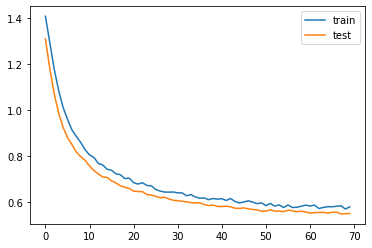

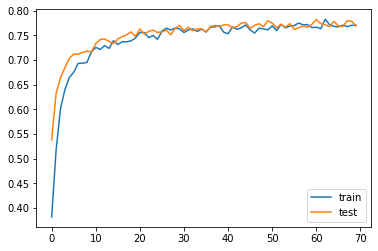

In [ ]:
[model, history] = train_transfer_learning()

## Save transfer learning model

In [ ]:
cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/Challenge_1/', 'classification_experiments')
model_name = 'transfer_learning'
exp_dir = os.path.join(exps_dir, model_name)
ckpt_dir = os.path.join(exp_dir, 'ckpts')
latest = tf.train.latest_checkpoint(ckpt_dir)
latest

print() # For \n

img_h = 600
img_w = 600

num_classes = 3

num_dense = 1
neurons_1 = 16

model = define_transfer_learning_model(img_h = img_h, img_w = img_w, num_dense = num_dense, neurons_1 = neurons_1, num_classes = num_classes)
model.load_weights(latest)

In [ ]:
# ---------------------------------------------
# Save the model trained with transfer learning
# ---------------------------------------------
! mkdir '/content/drive/My Drive/Challenge_1/model'
! mkdir '/content/drive/My Drive/Challenge_1/model/EffNet_B7_dense_16_NOdropout_transfer_learning_70epochs'
model.save('/content/drive/My Drive/Challenge_1/model/EffNet_B7_dense_16_NOdropout_transfer_learning_70epochs')

## Fine Tuning

--------------------------------------------
Image heigth                      ---> 600
Image width                       ---> 600
Batch size                        ---> 12
Dense layer number                ---> 1
Neurons in 1st dense              ---> 16
Learning rate                     ---> 5e-05
Number of epochs                  ---> 70
Model checkpoint                  ---> True
Visualize tensorboars             ---> False
Early stopping                    ---> True
Reduce learning rate on plateau   ---> True
--------------------------------------------
Found 4774 images belonging to 3 classes.
Found 840 images belonging to 3 classes.
258080768/258076736 [==============================] - 2s 0us/step
input_1                            ----> Trainable: False
rescaling                          ----> Trainable: False
normalization                      ----> Trainable: False
stem_conv_pad                      ----> Trainable: False
stem_conv                          ----> Trainable: F

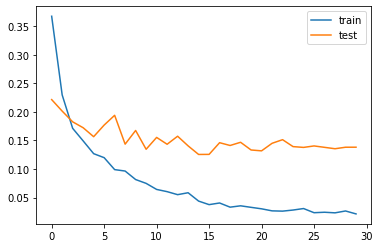

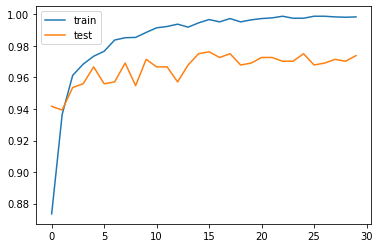

In [ ]:
[model, history] = train_fine_tuning()

# Result csv

In [ ]:
# Create folder for prediction files (csv)
! mkdir '/content/drive/My Drive/Challenge_1/result_csv'


# ------------------------------------
# Create the csv file with predictions
# ------------------------------------
def create_csv(results, results_dir='/content/drive/My Drive/Challenge_1/result_csv'):
  import os
  from datetime import datetime

  csv_fname = 'results_'
  csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

  with open(os.path.join(results_dir, csv_fname), 'w') as f:
    f.write('Id,Category\n')
    for key, value in results.items():
      f.write(key + ',' + str(value) + '\n')

In [45]:
! ls '/content/drive/My Drive/Challenge_1/result_csv'

In [46]:
# --------------------------------------
# Make predictions and save the csv file
# --------------------------------------
from PIL import Image

image_filenames = next(os.walk('/content/MaskDataset/test'))[2]

results = {}
for image_name in image_filenames:
  tmp_path = os.path.join(cwd, 'MaskDataset/test', image_name)

  img = Image.open(tmp_path).convert('RGB')
  img = img.resize((600, 600))

  img_array = np.array(img)
  img_array = np.expand_dims(img_array, 0) 
   
  # Data Normalization
  img_array = tf.keras.applications.efficientnet.preprocess_input(x=img_array)
  out_softmax = model.predict(x=img_array)

  prediction = tf.math.argmax(out_softmax, 1)   # predicted class

  results[image_name] = prediction[0].numpy()

create_csv(results)

! ls '/content/drive/My Drive/Challenge_1/result_csv'

results_Nov22_17-58-47.csv


In [ ]:
# ---------------------------------------
# Save the model trained with fine tuning
# ---------------------------------------
! mkdir '/content/drive/My Drive/Challenge_1/model'
! mkdir '/content/drive/My Drive/Challenge_1/model/EffNet_B7_dense_16_NOdropout_fine_tuning_block5-6-7'
model.save('/content/drive/My Drive/Challenge_1/model/EffNet_B7_dense_16_NOdropout_fine_tuning_block5-6-7')